In [11]:
try:
    from google.colab import drive
    from google.colab import output
    import os
    drive.mount('/content/drive')
    output.clear()
except ImportError:
    pass

In [13]:
from matplotlib import pyplot

In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16177097984092252725
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15602841720598490744
physical_device_desc: "device: XLA_CPU device"
]


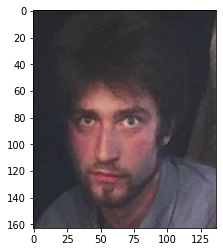

In [16]:
img_path = "/content/drive/MyDrive/recognition/11.jpg"
img = pyplot.imread(img_path)
pyplot.imshow(img)
pyplot.show()

In [18]:
from mtcnn.mtcnn import MTCNN
detector = MTCNN()
results = detector.detect_faces(img)
x1, y1, width, height = results[0]['box']
x2, y2 = x1 + width, y1 + height
face = img[y1:y2, x1:x2]

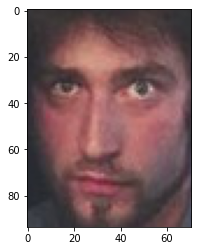

In [19]:
from PIL import Image
import numpy as np

image = Image.fromarray(face)
face_array = np.asarray(image)
pyplot.imshow(face_array)
pyplot.show()

In [24]:
def extract_face(filename, required_size=(224, 224), resize=False):
    """Функция возвращает массив-лицо и преобразует его к заданному размеру,
    если resize == True
    
    Параметры:
    filename -- строка - путь к файлу с исходным изображением
    required_size -- кортеж из двух целых чисел - размер финального изображения
    resize -- boolean, который определяет, нужно ли менять размер изображения
    
    Возвращает np.ndarray, в котором записано обрезанное изображение с найденным
    на первоначальной картинке лицом
    """
    pixels = pyplot.imread(filename)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    if resize:
        image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

def print_image(img):
    """Выводит изображение на экран"""
    if isinstance(img, str):
        img = pyplot.imread(img)
    pyplot.imshow(img)
    pyplot.show()

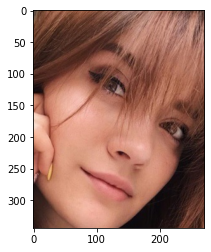

In [26]:
print_image(extract_face(f"/content/drive/MyDrive/recognition/3.jpg"))


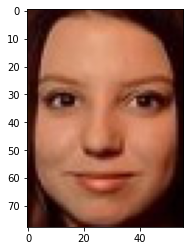

In [27]:
print_image(extract_face("/content/drive/MyDrive/recognition/6.jpg"))

In [82]:
from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation, Dense

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [83]:
from keras.models import model_from_json
model.load_weights('/content/drive/MyDrive/vgg_face_weights.h5')

In [84]:
# наш выходной слой с необходимым количеством нейронов в нем
final_layer = Dense(7, activation='softmax')(model.layers[-2].output)

from keras.models import Model
model = Model(model.inputs, final_layer)
for layer in model.layers[:-1]:
    layer.trainable = False

In [85]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [87]:
import os
dir1 = "/content/drive/MyDrive/recognition"
dir2 = "/content/drive/MyDrive/recognition_other"

files1 = os.listdir(dir1)
files2 = os.listdir(dir2)

In [88]:
images1 = [extract_face(os.path.join(dir1, i), resize=True)
           for i in files1]

images2 = [extract_face(os.path.join(dir2, i), resize=True)
           for i in files2]
    
output.clear()

In [89]:
X_train = images1
X_test = images2

In [117]:
y_train = np.array([[0., 0., 1., 0., 0., 0., 0.],
                    [1., 0., 0., 0., 0., 0., 0.],
                    [1., 0., 0., 0., 0., 0., 0.],
                    [0., 1., 0., 0., 0., 0., 0.],
                    [0., 1., 0., 0., 0., 0., 0.],
                    [0., 0., 1., 0., 0., 0., 0.],
                    [0., 1., 0., 0., 0., 0., 0.],
                    [0., 1., 0., 0., 0., 0., 0.],
                    [0., 0., 1., 0., 0., 0., 0.],
                    [0., 0., 1., 0., 0., 0., 0.],
                    [1., 0., 0., 0., 0., 0., 0.],
                    [1., 0., 0., 0., 0., 0., 0.],
                    [0., 0., 0., 1., 0., 0., 0.],
                    [0., 0., 0., 0., 1., 0., 0.],
                    [0., 0., 0., 0., 0., 1., 0.],
                    [0., 0., 0., 0., 0., 0., 1.],
                    [0., 0., 0., 1., 0., 0., 0.],
                    [0., 0., 0., 1., 0., 0., 0.],
                    [0., 0., 0., 1., 0., 0., 0.],
                    [0., 0., 0., 0., 1., 0., 0.],
                    [0., 0., 0., 0., 1., 0., 0.],
                    [0., 0., 0., 0., 1., 0., 0.],
                    [0., 0., 0., 0., 0., 1., 0.],
                    [0., 0., 0., 0., 0., 1., 0.],
                    [0., 0., 0., 0., 0., 1., 0.],
                    [0., 0., 0., 0., 0., 0., 1.],
                    [0., 0., 0., 0., 0., 0., 1.],
                    [0., 0., 0., 0., 0., 0., 1.]])

In [119]:
y_test  = np.array([[0., 0., 0., 0., 0., 1., 0.],
                    [0., 0., 0., 0., 1., 0., 0.],
                    [0., 0., 0., 0., 0., 0., 1.],
                    [0., 0., 0., 1., 0., 0., 0.],
                    [0., 0., 1., 0., 0., 0., 0.],
                    [0., 1., 0., 0., 0., 0., 0.],
                    [1., 0., 0., 0., 0., 0., 0.]])

In [120]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [93]:
train = train_datagen.flow(np.asarray(X_train), np.asarray(y_train))

In [123]:
%%time
model.fit_generator(train, epochs=10, verbose=1)

Epoch 1/10
1/1 [==============================] - 0s 1ms/step - loss: 0.8262 - accuracy: 0.8571
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.8388 - accuracy: 0.8214
Epoch 3/10
1/1 [==============================] - 0s 1ms/step - loss: 0.7982 - accuracy: 0.8571
Epoch 4/10
1/1 [==============================] - 0s 1ms/step - loss: 0.7688 - accuracy: 0.8571
Epoch 5/10
1/1 [==============================] - 0s 1ms/step - loss: 0.8675 - accuracy: 0.8214
Epoch 6/10
1/1 [==============================] - 0s 1ms/step - loss: 0.8074 - accuracy: 0.8214
Epoch 7/10
1/1 [==============================] - 0s 1ms/step - loss: 0.8012 - accuracy: 0.8571
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.8007 - accuracy: 0.8929
Epoch 9/10
1/1 [==============================] - 0s 1ms/step - loss: 0.8042 - accuracy: 0.8929
Epoch 10/10
1/1 [==============================] - 0s 1ms/step - loss: 0.8176 - accuracy: 0.8214
CPU times: user 4min 28s, sys: 660 ms, 

In [104]:
model.save_weights("l5_face_rec_model_weights.h5")

In [105]:
model.load_weights("l5_face_rec_model_weights.h5")

In [124]:
np.argmax(model.predict(np.asarray(X_test)), axis=0)

array([6, 5, 4, 0, 3, 0, 2])

In [127]:
np.argmax(y_test, axis=0)

array([6, 5, 4, 3, 1, 0, 2])

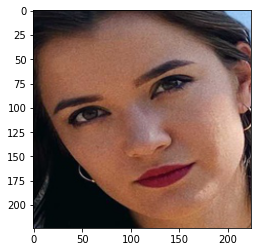

In [131]:
pyplot.imshow(Image.fromarray(X_test[6]))
pyplot.show()

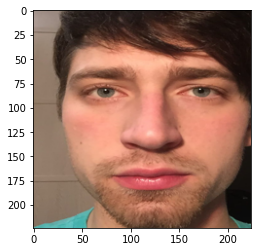

In [134]:
pyplot.imshow(Image.fromarray(X_test[4]))
pyplot.show()

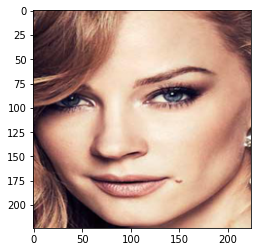

In [133]:
pyplot.imshow(Image.fromarray(X_test[3]))
pyplot.show()